In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
import numpy as np
import pandas as pd
import random


In [ ]:
#Import text as a list of strings.
data = open('processed_data/extremoduro_processed.txt', 'r').read()


#Tokenize database
corpus = data

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1


print(total_words)
print(tokenizer.word_index)

In [ ]:
input_sequences = []

for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
#Train model
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.4))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu'))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(xs, ys, epochs=300, verbose=1)

print(model)
print(model.summary())

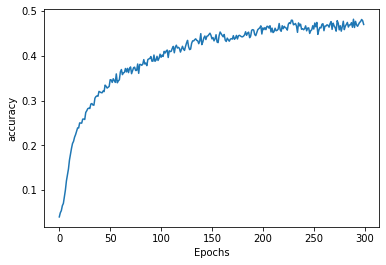

In [ ]:
def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

plot_graph(history, 'accuracy')

In [ ]:
#Generate text from a random seed contained in the dataset

seed_text = random.choice(list(tokenizer.word_index.keys()))
next_words = 200
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
    else:
      seed_text += " " + output_word
    
print(seed_text)